In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM,Dropout,Dense,Activation

import datetime

In [9]:
data = pd.read_csv('data/samsung.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-24,21760,22300,20660,21580,217.796982,22429600
1,2015-08-25,21580,22140,21340,21580,217.796982,19625950
2,2015-08-26,21360,21480,21000,21340,215.374756,27947600
3,2015-08-27,21640,21720,21260,21340,215.374756,24769400
4,2015-08-28,21720,21720,21460,21620,218.200653,23111150


In [10]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices+low_prices)/2

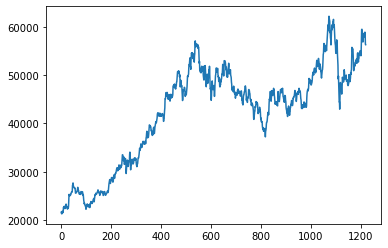

In [11]:
plt.plot(mid_prices)

In [34]:
seq_len = 50 # 최근 50일을 보고 미래를 예측할 것이므로
sequence_length = seq_len + 1

result = []

for index in range(len(mid_prices)-sequence_length):
    result.append(mid_prices[index:index+sequence_length])

In [35]:
# z-score 정규화(평균값에서 표준편차의 몇배 정도 떨어져있다를 평가하는 수치)
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window))/ np.std(window))for p in window]
    normalized_data.append(normalized_window)
    #복원을 위해 저장
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))
    
result = np.array(normalized_data)

# 훈련데이터는 전체중에 90%를 사용할 예정
row = int(round(result.shape[0]*0.9))
train = result[:row,:]
np.random.shuffle(train) # 훈련데이터를 랜덤으로 섞음

x_train = train[:,:-1]
x_train = np.reshape(x_train,(train.shape[0], x_train.shape[1],1))
y_train = train[:,-1]

x_test = result[row:,:-1]
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
y_test = result[row:,-1]

x_train.shape,x_test.shape

((1053, 50, 1), (117, 50, 1))

In [36]:
# 모델 생성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(1,activation='linear')) #다음날 하루를 구하므로
model.compile(loss='mse',optimizer='rmsprop')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [48]:
# 훈련
model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=10,epochs=30)

Train on 1053 samples, validate on 314 samples
Epoch 1/30
1053/1053 [==============================] - 9s 9ms/sample - loss: 0.1460 - val_loss: 0.1495
Epoch 2/30
1053/1053 [==============================] - 9s 9ms/sample - loss: 0.1426 - val_loss: 0.1501
Epoch 3/30
1053/1053 [==============================] - 9s 8ms/sample - loss: 0.1398 - val_loss: 0.1308
Epoch 4/30
1053/1053 [==============================] - 9s 8ms/sample - loss: 0.1436 - val_loss: 0.1240
Epoch 5/30
1053/1053 [==============================] - 10s 9ms/sample - loss: 0.1417 - val_loss: 0.1250
Epoch 6/30
1053/1053 [==============================] - 12s 12ms/sample - loss: 0.1414 - val_loss: 0.1264
Epoch 7/30
1053/1053 [==============================] - 11s 10ms/sample - loss: 0.1409 - val_loss: 0.1305
Epoch 8/30
1053/1053 [==============================] - 11s 11ms/sample - loss: 0.1410 - val_loss: 0.1304
Epoch 9/30
1053/1053 [==============================] - 12s 11ms/sample - loss: 0.1407 - val_loss: 0.1345
Epoch 10

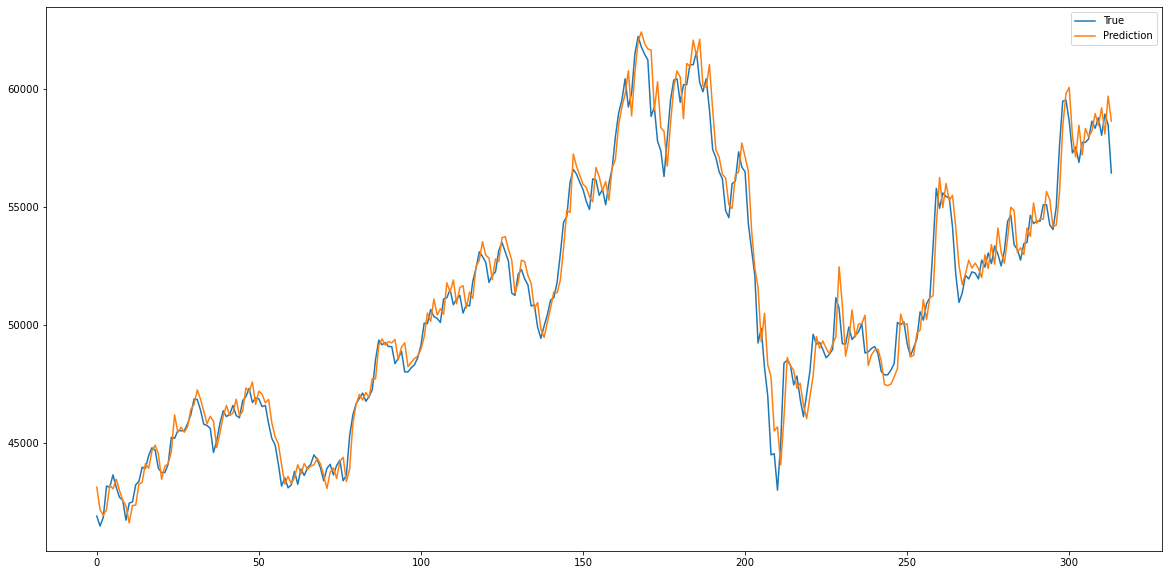

In [49]:
#검증 및 그래프
pred = model.predict(x_test)

pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)
    
fig = plt.figure(facecolor='white', figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(pred_y,label='True')
ax.plot(pred_result,label='Prediction')
ax.legend()
plt.show()

In [50]:
lt = mid_prices[-365:]
len(lt)

365

In [40]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(lt) - sequence_length):
    result.append(lt[index: index + sequence_length])

In [41]:
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) for p in window]
    normalized_data.append(normalized_window)
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

result = np.array(normalized_data)

x_test = result[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[:, -1]

x_test.shape

(314, 50, 1)

In [42]:
pred = model.predict(x_test)

In [43]:
pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)

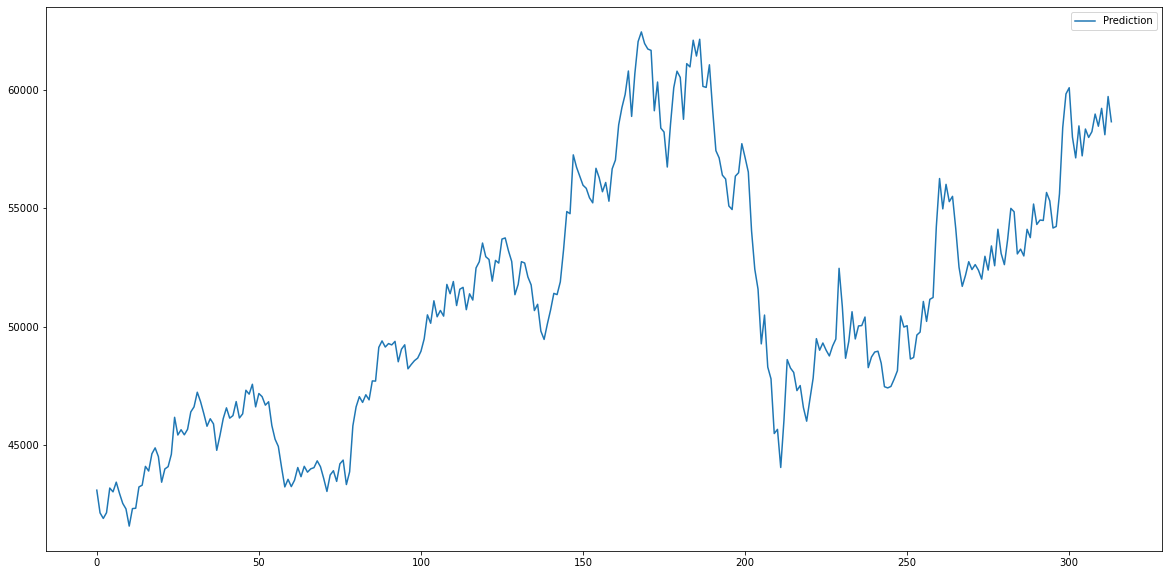

2020년 8월 21일의 주가는 58102.75
2020년 8월 22일의 주가는 59715.27
2020년 8월 23일의 주가는 58651.30


In [55]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()

print('2020년 8월 21일의 주가는', '%0.2f'%float(pred_result[-3]))
print('2020년 8월 22일의 주가는', '%0.2f'%float(pred_result[-2]))
print('2020년 8월 23일의 주가는', '%0.2f'%float(pred_result[-1]))